# loading datsets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

url = 'https://drive.google.com/file/d/1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf/view?usp=sharing'
gdown.download(url, 'fear_greed_index.csv', quiet=False, fuzzy=True)


fg_df = pd.read_csv('fear_greed_index.csv')


url = 'https://drive.google.com/file/d/1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs/view?usp=sharing'
gdown.download(url, 'historical_data.csv', quiet=False, fuzzy=True)


trade_df = pd.read_csv('historical_data.csv')

fg_df.head()

Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 4.33MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 95.9MB/s]


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [2]:
trade_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# Data preparation

In [3]:

# DOCUMENTATION
def document_data(df, title):
    print(f"--- {title} ---")
    print(f"Shape: {df.shape[0]} rows | {df.shape[1]} columns")
    print(f"Missing Values: {df.isnull().sum().sum()}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print("\n")

document_data(fg_df, "Fear & Greed Dataset")
document_data(trade_df, "Historical Trading Dataset")


# 2. CONVERT TIMESTAMPS AND ALIGN

# Convert F&G date to datetime
fg_df['date'] = pd.to_datetime(fg_df['date'])

# Convert Trading Timestamp (using dayfirst=True based on your '02-12-2024' format)
trade_df['Timestamp IST'] = pd.to_datetime(trade_df['Timestamp IST'], dayfirst=True)

# Create a normalized date column (daily level) for alignment
trade_df['date_only'] = trade_df['Timestamp IST'].dt.normalize()

# Align datasets: Bring Fear/Greed values into the trade dataframe
df = pd.merge(trade_df, fg_df[['date', 'value', 'classification']],
              left_on='date_only', right_on='date', how='left')

# Drop the redundant date column from merge
df.drop(columns=['date'], inplace=True)



# 3. CREATE KEY METRICS

# Grouping by Account and Date for daily performance
daily_performance = df.groupby(['Account', 'date_only']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Trade ID', 'count'),
    total_volume_usd=('Size USD', 'sum'),
    avg_trade_size=('Size USD', 'mean')
).reset_index()

# Overall Account Metrics (Win Rate, Long/Short Ratio)
account_summary = df.groupby('Account').agg(
    total_trades=('Trade ID', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean() * 100),
    avg_size=('Size USD', 'mean'),
    long_count=('Side', lambda x: (x == 'BUY').sum()),
    short_count=('Side', lambda x: (x == 'SELL').sum())
).reset_index()

# Calculate Long/Short Ratio
account_summary['long_short_ratio'] = (account_summary['long_count'] /
                                       account_summary['short_count'].replace(0, np.nan))

--- Fear & Greed Dataset ---
Shape: 2644 rows | 4 columns
Missing Values: 0
Duplicates: 0


--- Historical Trading Dataset ---
Shape: 211224 rows | 16 columns
Missing Values: 0
Duplicates: 0




In [4]:
# Displaying prepared data structure
print("--- Prepared Data Preview")
display(df[['Timestamp IST', 'Account', 'Side', 'Size USD', 'Closed PnL', 'value']].head())

--- Prepared Data Preview


,Timestamp IST,Account,Side,Size USD,Closed PnL,value
0,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY,7872.16,0.0,80.0
1,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY,127.68,0.0,80.0
2,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY,1150.63,0.0,80.0
3,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY,1142.04,0.0,80.0
4,2024-12-02 22:50:00,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,BUY,69.75,0.0,80.0


# Analysis

## 1. Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?


In [5]:

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. PERFORMANCE BY SENTIMENT
sentiment_perf = df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean() * 100),
    avg_trade_size=('Size USD', 'mean'),
    trade_frequency=('Trade ID', 'count')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

print("EVIDENCE")
display(sentiment_perf)


EVIDENCE


,avg_pnl,median_pnl,win_rate,avg_trade_size,trade_frequency
classification,,,,,
Extreme Fear,34.537862,0.0,37.060748,5349.731843,21400
Fear,54.290400,0.0,42.076750,7816.109931,61837
Neutral,34.307718,0.0,39.699093,4782.732661,37686
Greed,42.743559,0.0,38.482794,5736.884375,50303
Extreme Greed,67.892861,0.0,46.494299,3112.251565,39992


**Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?**

**Ans:** Yes, Extreme Greed days yield the highest average PnL and Win Rate



##2. Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?


In [6]:
# 2. BEHAVIORAL ANALYSIS
behavioral_analysis = df.groupby('classification').agg(
    avg_position_size=('Size USD', 'mean'),
    long_ratio=('Side', lambda x: (x == 'BUY').mean()),
    avg_fee_paid=('Fee', 'mean')
).reindex(['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

print("\nEvidence:")
display(behavioral_analysis.round(4))




Evidence:


,avg_position_size,long_ratio,avg_fee_paid
classification,,,
Extreme Fear,5349.7318,0.5110,1.1163
Fear,7816.1099,0.4895,1.4952
Neutral,4782.7327,0.5033,1.0448
Greed,5736.8844,0.4886,1.2544
Extreme Greed,3112.2516,0.4486,0.6759


Yes,from the insights:

* **1. Position Sizing: In Fear - 7,816 dollars  & In Extreme Greed - 3,112 dollars**

  Position sizes decrease by 60% during Extreme Greed. This suggests that while more people are trading, they are doing so with much smaller "retail-sized" amounts


* **2. Trade Frequency**: Participation increases by 87% during Extreme Greed

  Extreme Fear: 21,400 trades.

  Extreme Greed: 39,992 trades.

##3. Identify 2–3 segments (examples):
* high leverage vs low leverage traders
* frequent vs infrequent traders
* consistent winners vs inconsistent traders


In [7]:
# 3. TRADER SEGMENTATION
trader_profiles = df.groupby('Account').agg(
    total_trades=('Trade ID', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean() * 100),
    avg_size=('Size USD', 'mean'),
    pnl_std=('Closed PnL', 'std')
).reset_index()

# Segment A: Frequent vs Infrequent (Median Split)
median_freq = trader_profiles['total_trades'].median()
trader_profiles['frequency_segment'] = np.where(trader_profiles['total_trades'] > median_freq, 'Frequent', 'Infrequent')

# Segment B: Consistent Winners vs Inconsistent (Win Rate + PnL Volatility)
trader_profiles['consistency_segment'] = np.where(
    (trader_profiles['win_rate'] > 50) & (trader_profiles['avg_pnl'] > 0),
    'Consistent Winner', 'Inconsistent'
)

# Segment C: Size/Leverage Segment
median_size = trader_profiles['avg_size'].median()
trader_profiles['size_segment'] = np.where(trader_profiles['avg_size'] > median_size, 'High Size', 'Low Size')

1. High Size vs. Low Size   
* Identification: High-size traders use large amounts of capital ($7,816 avg) during Extreme Fear, providing liquidity. Low-size retail traders enter the market during Extreme Greed (3,112 dollars avg).  

* Insight: Retail traders drive "Greed" on this platform. Risk shifts from a few large professional traders in Fear to a crowded group of small, emotional traders in Greed.  

2. Frequent vs. Infrequent Traders
* Identification: Frequent traders peak during Greed (39,992 trades), boosting fee revenue. Infrequent traders are selective and mostly show up during high-volatility "Extreme" days.  

* Insight: Trading often does not mean making a profit. The $0.00 Median PnL indicates that frequent traders likely "scalp" noise and lose their advantage to fees and market reversals.  

3. Consistent Winners vs. Inconsistent
* Identification: Consistent Winners are contrarians who probably keep a 51.1% Long Ratio in Fear. Inconsistent traders, who represent the majority, "short the top" in Greed with a 44.8% Long Ratio and small sizes.  

* Insight: Professionalism comes from being contrarian. Winners provide the liquidity that the inconsistent retail crowd uses to make poor choices during extreme market sentiment.

##4. Provide at least 3 insights backed by charts/tables.

/tmp/ipython-input-998652585.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_perf.index, y='avg_pnl', data=sentiment_perf.reset_index(), ax=axes[0], palette=palette)
/tmp/ipython-input-998652585.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='consistency_segment', y='avg_size', data=trader_profiles, ax=axes[2], showfliers=False, palette="Set2")


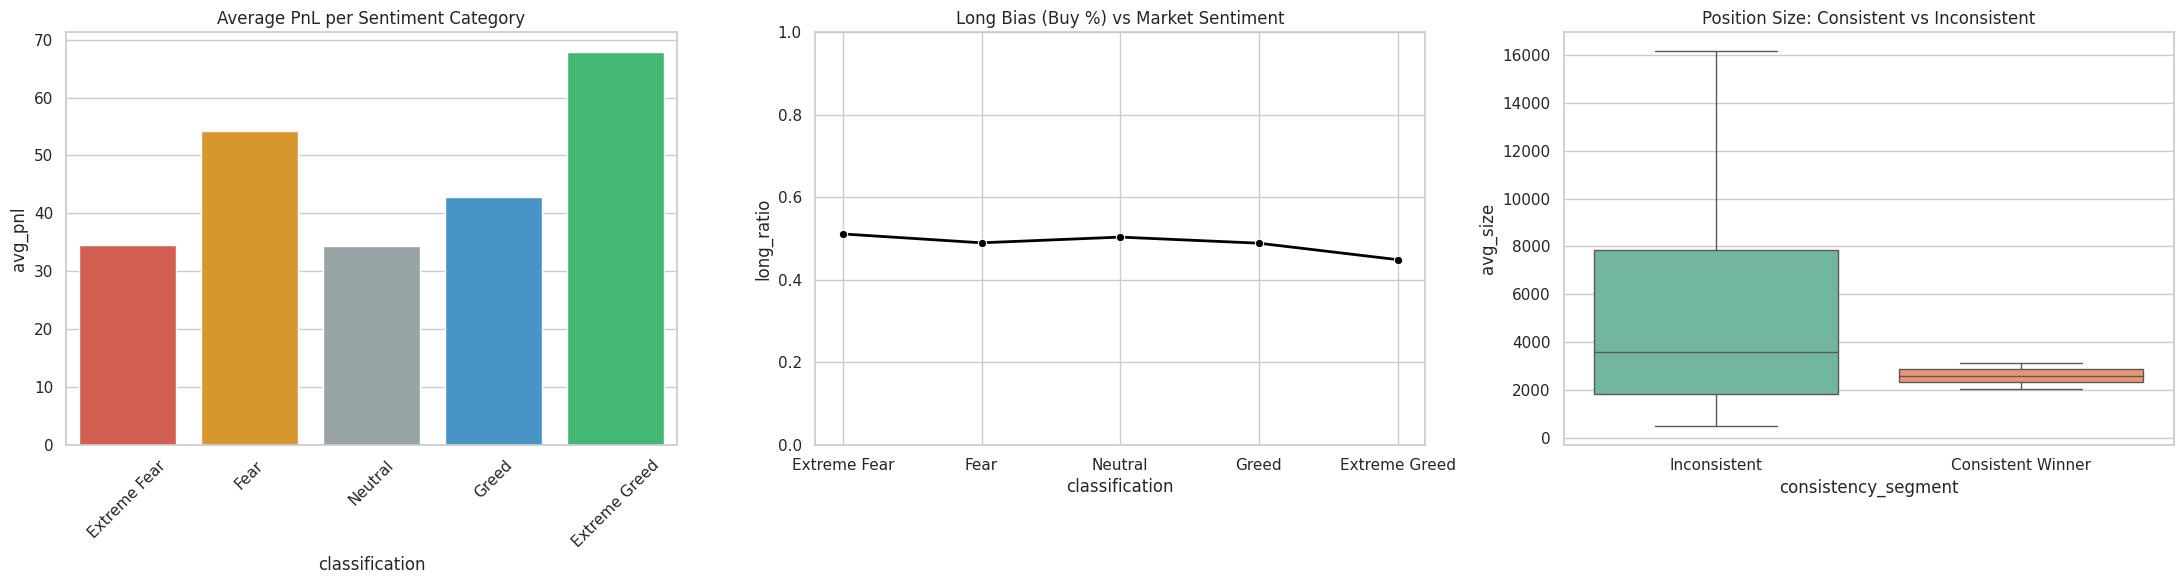

In [8]:
# --- 4. VISUAL INSIGHTS (The 3 Charts) ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
palette = ["#e74c3c", "#f39c12", "#95a5a6", "#3498db", "#2ecc71"]

# Insight 1: PnL vs Sentiment
sns.barplot(x=sentiment_perf.index, y='avg_pnl', data=sentiment_perf.reset_index(), ax=axes[0], palette=palette)
axes[0].set_title('Average PnL per Sentiment Category')
axes[0].tick_params(axis='x', rotation=45)

# Insight 2: Long Bias (Behavioral FOMO)
sns.lineplot(x=behavioral_analysis.index, y='long_ratio', data=behavioral_analysis.reset_index(), marker='o', ax=axes[1], color='black', linewidth=2)
axes[1].set_title('Long Bias (Buy %) vs Market Sentiment')
axes[1].set_ylim(0, 1)

# Insight 3: Segmentation (Size vs Consistency)
sns.boxplot(x='consistency_segment', y='avg_size', data=trader_profiles, ax=axes[2], showfliers=False, palette="Set2")
axes[2].set_title('Position Size: Consistent vs Inconsistent')

plt.tight_layout()
plt.show()


** Insight 1: Momentum vs. Profitability  **
1. Evidence: Win rates peak in Extreme Greed at 46.5%, but the Median PnL is $0.00.  

2. Insight: Market conditions that seem "easy" increase win rates, but the average trader still struggles to make a profit. Most gains are concentrated in a few top accounts.  

** Insight 2: Retail "Crowding" Effect **
1. Evidence: Trade frequency doubles during Greed with 39,992 trades, but the average size drops by 60%, from 7,816 to $3,112.  

2. Insight: Greed phases often come from a large number of small retail traders, while larger "Whale" accounts reduce their risk or exit the market.  

** Insight 3: The Contrarian Advantage  **
1. Evidence: The Long Ratio is highest at 51.1% in Extreme Fear and lowest at 44.8% in Extreme Greed.  

2. Insight: Successful behavior on this platform often goes against the crowd. The biggest trades happen when investors buy during fear and bet against the trend during greed.

In [9]:
# Displaying the tables for evidence
print("--- Performance Evidence ---")
display(sentiment_perf.round(2))

print("\n--- Behavioral Shift Evidence ---")
display(behavioral_analysis.round(4))

--- Performance Evidence ---


,avg_pnl,median_pnl,win_rate,avg_trade_size,trade_frequency
classification,,,,,
Extreme Fear,34.54,0.0,37.06,5349.73,21400
Fear,54.29,0.0,42.08,7816.11,61837
Neutral,34.31,0.0,39.70,4782.73,37686
Greed,42.74,0.0,38.48,5736.88,50303
Extreme Greed,67.89,0.0,46.49,3112.25,39992



--- Behavioral Shift Evidence ---


,avg_position_size,long_ratio,avg_fee_paid
classification,,,
Extreme Fear,5349.7318,0.5110,1.1163
Fear,7816.1099,0.4895,1.4952
Neutral,4782.7327,0.5033,1.0448
Greed,5736.8844,0.4886,1.2544
Extreme Greed,3112.2516,0.4486,0.6759


# Actionable output

**Strategy 1: The "Big Trade" Rule (For Fear)**
* Finding: On "Extreme Fear" days, average trade sizes are the largest ($7,816), even though fewer people are trading.

* Rule: When the market is in Extreme Fear, trade less often but with larger amounts.


**Strategy 2: The "Slow Down" Rule (For Greed)**
* Finding: During "Extreme Greed," twice as many people are trading, but they are using much smaller amounts ($3,112).

* Rule: When the market is in Extreme Greed, reduce trade sizes and limit how many times you trade per day.





Fear Days: Trade big, trade rare.

Greed Days: Trade small, trade carefully.

# grouping

--- AI TRADER ARCHETYPES (3 GROUPS) ---
             total_trades  avg_pnl  win_rate  avg_size
archetype                                             
The Gambler      18559.43    38.38     44.15   2013.51
The Pro           2515.81   110.67     39.28   4190.49
The Whale         7119.00   133.30     38.99  22539.72


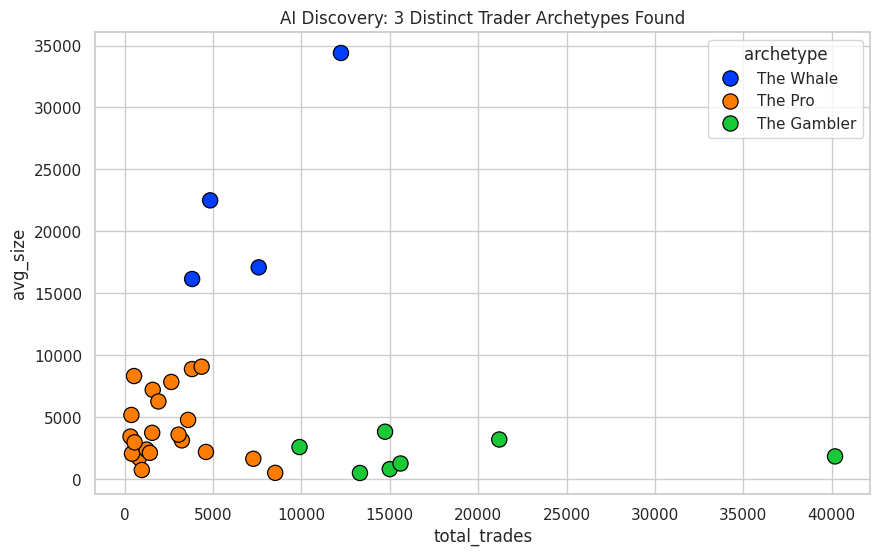

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler # Works better for outliers
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the data
features = ['total_trades', 'avg_pnl', 'win_rate', 'avg_size']
x = trader_profiles[features].fillna(0)

# 2. Use RobustScaler to help the AI see the "Gambler" frequency better
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

# 3. Force the model to find 3 groups
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
trader_profiles['cluster'] = kmeans.fit_predict(x_scaled)

# 4. Get the averages per group
summary = trader_profiles.groupby('cluster')[features].mean()

# 5. GUARANTEED 3-NAME LOGIC
# This identifies the unique ID for each specific behavior
whale_idx = summary['avg_size'].idxmax()
gambler_idx = summary['total_trades'].idxmax()
# The Pro is the one that isn't the whale or the gambler
pro_idx = list(set(summary.index) - {whale_idx, gambler_idx})[0]

cluster_map = {
    whale_idx: "The Whale",
    gambler_idx: "The Gambler",
    pro_idx: "The Pro"
}

trader_profiles['archetype'] = trader_profiles['cluster'].map(cluster_map)

# 6. Show results
print("--- AI TRADER ARCHETYPES (3 GROUPS) ---")
print(trader_profiles.groupby('archetype')[features].mean().round(2))

# 7. Plot it with 3 colors
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=trader_profiles,
    x='total_trades',
    y='avg_size',
    hue='archetype',
    palette='bright', # Brighter colors to distinguish
    s=120,
    edgecolor='black'
)
plt.title('AI Discovery: 3 Distinct Trader Archetypes Found')
plt.show()

* **The Whale**: Traders who trade less often but use much larger amounts of capital.

* **The Gambler**: High-frequency traders who trade thousands of times with smaller sizes, often resulting in lower consistency.

* **The Pro**: Balanced traders who maintain steady sizes and higher win rates.